In [1]:
# The notebook will look at outlier identification and removal.
# Why is this so important? We want ot make sure the data we are modelling is represnetative of the population.
# If for some data collection issues outliers are present which arent reflective then this creates issues in modelling and 
# hence inference and predictive nature of models.
# But we need to be sure an outlier is that as opposed to being part of the general population distribution. 
# ie data measurement issue, data corruption.

In [2]:
# one way of removing outliers is the standard deviation method. Ie any sample which is outside a certain range
# of the standard deviation we remove it 

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
from numpy.random import seed
from numpy.random import randn



In [9]:
seed =42
# we generate 10000 random normal distrubted numbers 

# consider mean 100 std = 4
data = 4*randn(10000)+100

In [10]:
print(np.mean(data), np.std(data))

99.92814817626336 3.9577716425909872


In [ ]:
# as we can see this is line with what we wante to simulate


Text(0, 0.5, 'frequency')

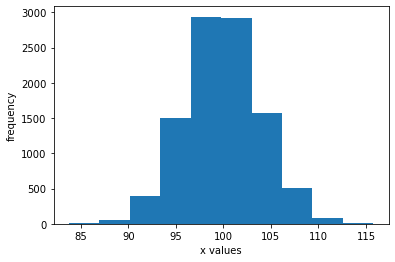

In [13]:
import matplotlib.pyplot as plt
plt.hist(data)
plt.xlabel('x values')
plt.ylabel( 'frequency')

In [16]:
# we want to remove any values which are 3 * std away from mean 

lower = np.mean(data) - 3*np.std(data) 
higher = np.mean(data) + 3*np.std(data) 

In [20]:
outliers = [x for x in data if x>higher or x <lower ]

In [21]:
outliers_removed = [x for x in data if x<higher and x >lower ]

In [25]:
print ('outliers removed {}'.format(len(outliers_removed)))

outliers removed 9974


In [26]:
print ('outliers present {}'.format(len(outliers)))

outliers present 26


In [28]:
# nb this is only consdiering one dimensional range. Also using the standard deviation approach only really works 
# in a normal/ Gaussain distrbuted world 

In [29]:
# in non gaussian world, its worthwhile to consdier interquartile range 

In [30]:
from numpy import percentile

In [33]:
q25 , q75 = percentile(data ,25), percentile(data ,75)

In [35]:
iqr = q75 -q25

In [36]:
iqr

5.345574834209259

In [37]:
lower , upper = q25 - 1.5*iqr , q75+1.5*iqr 

In [38]:
lower, upper

(89.23917223250115, 110.62147156933818)

In [40]:
outliers = [x for x in data if x > upper or x <lower ]

In [41]:
outlier_removed = [x for x in data if x < upper and x > lower ]

In [44]:
print(len(outliers), len(outlier_removed))

75 9925


In [46]:
# so far we have looked at standard deviation and IQR method.
# Final piece is to look at Automatic Outlier Detection 
# This method works by locating examples that are far from the other examples in the multidimensional feature space
# works well for low feature but less reliable as features increase
# Method works in the following manner:
# LOF : Local outlier factor is a technique that attempts to harness the idea of nearest neighbors 
# for outlier detection 
# Each example is assigned a scoring of how isolated or likely it is to be outliers 
# example with the largest score are outliers 


In [63]:
# we using the boston housing data set 
df_raw_housing= pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv', header =None)

In [64]:
df_raw_housing.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [65]:
df_raw_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       506 non-null    float64
 1   1       506 non-null    float64
 2   2       506 non-null    float64
 3   3       506 non-null    int64  
 4   4       506 non-null    float64
 5   5       506 non-null    float64
 6   6       506 non-null    float64
 7   7       506 non-null    float64
 8   8       506 non-null    int64  
 9   9       506 non-null    float64
 10  10      506 non-null    float64
 11  11      506 non-null    float64
 12  12      506 non-null    float64
 13  13      506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [66]:
df_raw_housing.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [67]:
from sklearn.model_selection import train_test_split

In [69]:
X = df_raw_housing.drop([13],axis =1)
y = df_raw_housing[13]

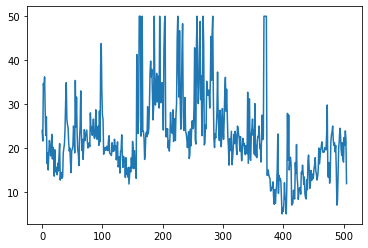

In [71]:
plt.plot(y)

In [72]:
X.shape

(506, 13)

In [73]:
df_raw_housing[13]

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: 13, Length: 506, dtype: float64

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size =0.3, random_state =1)

In [104]:
from sklearn.linear_model import LinearRegression

In [105]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [106]:
model =LinearRegression()

In [107]:
model.fit(X_train,y_train)

LinearRegression()

In [108]:
y_predict = model.predict(X_test)

In [109]:
print(mean_squared_error(y_predict,y_test) , mean_absolute_error(y_predict, y_test))

19.83132367206323 3.344665503598751


In [110]:
#can we do better by removing outliers?

In [111]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
outlier_ = lof.fit_predict(X_train)

In [112]:
get_in = outlier_ !=-1

In [113]:
model =LinearRegression()
model.fit(X_train[get_in], y_train[get_in])

LinearRegression()

In [114]:
y_predict1 = model.predict(X_test)

In [115]:
print(mean_absolute_error(y_predict1, y_test),mean_squared_error(y_predict1, y_test))

3.3360024869092153 19.574940993873092


In [116]:
# we can also look to use IsolationForest  as another way of detecting outliers